In [1]:
import pandas as pd
import geopandas

In [2]:
file_path = 'Datasets/Population_VNM_2020_1km_Aggregated_UNadj.csv'
pop = pd.read_csv(file_path)

In [3]:
pop = geopandas.GeoDataFrame(
    pop, geometry=geopandas.points_from_xy(pop.X, pop.Y))

In [4]:
pop.rename(columns={'X':'x','Y':'y'},inplace=True)

In [5]:
vietnamBoundaries = geopandas.read_file('Datasets/Vietnam_Administrative_Boundaries.geojson')

In [56]:
hospitals = geopandas.read_file('20210930_hospitalsNodesMerge.shp')

In [57]:
hospitals["x"] = hospitals.centroid.x
hospitals["y"] = hospitals.centroid.y

<ipython-input-57-0d4241c28bf7>:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hospitals["x"] = hospitals.centroid.x
<ipython-input-57-0d4241c28bf7>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  hospitals["y"] = hospitals.centroid.y


In [58]:
import osmnx as ox
import networkx as nx
import pandana
import numpy as np

In [59]:
#from pyrosm import OSM, get_data

In [60]:
ox.config(use_cache=True, log_console=True)

In [61]:
#network = ox.graph_from_xml('Datasets/highways2.osm')

In [62]:
network = ox.load_graphml('Datasets/20210928networkGraph.graphml')

In [63]:
#file_path = 'Datasets/20210928networkGraph.graphml'
#ox.save_graphml(G, filepath=file_path)

In [64]:
from sklearn.neighbors import BallTree
import numpy as np
import mapclassify as mc
import matplotlib.pyplot as plt
import time

def get_igraph_nodes(G):
    """Retrieves a frame from nodes of the igaph"""
    attributes = G.vs.attribute_names()
    if len(attributes) == 0:
        raise ValueError("Nodes does not have data.")
    data = {name: G.vs[name] for name in attributes}
    if "geometry" in attributes:
        return gpd.GeoDataFrame(data, 
                                geometry="geometry", 
                                crs="epsg:4326")
    return pd.DataFrame(data)

def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""
    tree = BallTree(candidates, leaf_size=15, metric='haversine')
    distances, indices = tree.query(src_points, k=k_neighbors)
    distances = distances.transpose()
    indices = indices.transpose()
    closest = indices[0]
    closest_dist = distances[0]
    return (closest, closest_dist)

def nearest_neighbor(left_gdf, right_gdf, return_dist=False):
    """
    For each point in left_gdf, find closest point in right GeoDataFrame and return them.
    
    For further info, take a look this lesson: 
        https://autogis-site.readthedocs.io/en/latest/notebooks/L3/06_nearest-neighbor-faster.html
    """
    left_geom_col = left_gdf.geometry.name
    right_geom_col = right_gdf.geometry.name
    right = right_gdf.copy().reset_index(drop=True)
    left_radians = np.array(left_gdf[left_geom_col].apply(lambda geom: 
                                                          (geom.x * np.pi / 180, geom.y * np.pi / 180)
                                                         ).to_list())
    right_radians = np.array(right[right_geom_col].apply(lambda geom: 
                                                         (geom.x * np.pi / 180, geom.y * np.pi / 180)
                                                        ).to_list())
    closest, dist = get_nearest(src_points=left_radians, candidates=right_radians)
    closest_points = right.loc[closest]
    closest_points = closest_points.reset_index(drop=True)
    if return_dist:
        earth_radius = 6371000  # meters
        closest_points['distance'] = dist * earth_radius
    return closest_points

def find_nearest_nodeids(nodes, src_gdf):
    """Finds the nearest node-ids for all points in 'src_gdf'."""
    nearest = nearest_neighbor(src_gdf, nodes, return_dist=True)
    return list(set(nearest["node_id"].values)), nearest["distance"].values

In [160]:
nodes = ox.graph_to_gdfs(network,nodes=True,edges=False)

In [171]:
nodes

,y,x,highway,ref,geometry
osmid,,,,,
75617751,21.025441,105.853216,NaN,NaN,POINT (105.85322 21.02544)
75618029,21.024871,105.855136,NaN,NaN,POINT (105.85514 21.02487)
76483008,21.080720,105.788689,NaN,NaN,POINT (105.78869 21.08072)
80399585,10.702306,105.108761,NaN,NaN,POINT (105.10876 10.70231)
81804025,21.027742,105.834221,NaN,NaN,POINT (105.83422 21.02774)
...,...,...,...,...,...
9115673217,22.835425,106.529890,NaN,NaN,POINT (106.52989 22.83543)
9115673220,22.836572,106.528676,NaN,NaN,POINT (106.52868 22.83657)
9115673228,22.837678,106.527039,NaN,NaN,POINT (106.52704 22.83768)


In [162]:
edges = ox.graph_to_gdfs(network,nodes=False,edges=True)

In [168]:
edges.columns

Index(['osmid', 'lanes', 'name', 'highway', 'oneway', 'length', 'geometry',
       'junction', 'ref', 'maxspeed', 'bridge', 'access', 'tunnel', 'width',
       'service', 'est_width'],
      dtype='object')

In [169]:
nodes.columns

Index(['y', 'x', 'highway', 'ref', 'geometry'], dtype='object')

In [67]:
# Create graph
G = network

In [158]:
edges.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
MultiIndex: 105163 entries, (75617751, 75618029, 0) to (9120652278, 411919037, 0)
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   osmid      105163 non-null  object  
 1   lanes      12256 non-null   object  
 2   name       50408 non-null   object  
 3   highway    105163 non-null  object  
 4   oneway     105163 non-null  bool    
 5   length     105163 non-null  float64 
 6   geometry   105163 non-null  geometry
 7   junction   4581 non-null    object  
 8   ref        28251 non-null   object  
 9   maxspeed   4991 non-null    object  
 10  bridge     18120 non-null   object  
 11  access     249 non-null     object  
 12  tunnel     355 non-null     object  
 13  width      381 non-null     object  
 14  service    35 non-null      object  
 15  est_width  4 non-null       object  
dtypes: bool(1), float64(1), geometry(1), object(13)
memory usage: 15.7+ MB


In [68]:
src_ids, euclidean_distance = ox.distance.nearest_nodes(G=network,X=hospitals['x'], Y=hospitals['y'],return_dist=True)

In [69]:
src_idsPop, euclidean_distancePop = ox.distance.nearest_nodes(G=network,X=pop['x'], Y=pop['y'],return_dist=True)

In [70]:
import igraph

In [71]:
src_cnt = len(src_ids)

In [72]:
nodes

,y,x,highway,ref,geometry
osmid,,,,,
75617751,21.025441,105.853216,NaN,NaN,POINT (105.85322 21.02544)
75618029,21.024871,105.855136,NaN,NaN,POINT (105.85514 21.02487)
76483008,21.080720,105.788689,NaN,NaN,POINT (105.78869 21.08072)
80399585,10.702306,105.108761,NaN,NaN,POINT (105.10876 10.70231)
81804025,21.027742,105.834221,NaN,NaN,POINT (105.83422 21.02774)
...,...,...,...,...,...
9115673217,22.835425,106.529890,NaN,NaN,POINT (106.52989 22.83543)
9115673220,22.836572,106.528676,NaN,NaN,POINT (106.52868 22.83657)
9115673228,22.837678,106.527039,NaN,NaN,POINT (106.52704 22.83768)


In [73]:
# Calculate distance to the closest hospital
nodes["distance_to_closest"] = nodes.iloc[:, -src_cnt:].min(axis=1)

# At this point you could already see the catchment areas from each road network node 
# to the closest hospital.
# Comment out the following if you want to see:
# ax = nodes.plot(column="distance_to_closest", cmap="RdYlBu", markersize=0.5)

<ipython-input-73-89a1e2adfa50>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  nodes["distance_to_closest"] = nodes.iloc[:, -src_cnt:].min(axis=1)


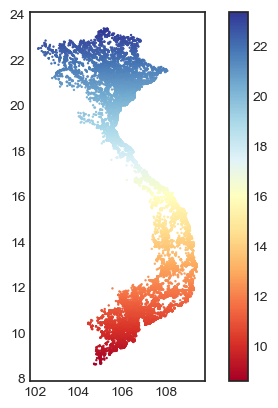

In [100]:
ax = nodes.plot(column="distance_to_closest", cmap="RdYlBu", markersize=0.5,legend=True)

In [75]:
hospitals['node_id'] = 0

In [97]:
pop

,x,y,Z,geometry,node_id,distance_to_closest_node
0,105.319583,23.395417,56.801758,POINT (105.31958 23.39542),2522145872,1001.992361
1,105.294583,23.387083,69.821190,POINT (105.29458 23.38708),7968676755,2259.617990
2,105.302916,23.387083,61.812702,POINT (105.30292 23.38708),2522145872,1858.869236
3,105.311250,23.387083,50.627831,POINT (105.31125 23.38708),2522145872,1076.340540
4,105.319583,23.387083,87.299217,POINT (105.31958 23.38708),2522145872,760.847273
...,...,...,...,...,...,...
406779,104.894583,8.570417,17.621071,POINT (104.89458 8.57042),4889231212,9384.317624
406780,104.827916,8.562083,16.502373,POINT (104.82792 8.56208),4889180335,2326.418657
406781,104.836250,8.562083,31.207506,POINT (104.83625 8.56208),4889180335,3173.669261
406782,104.844583,8.562083,29.299860,POINT (104.84458 8.56208),4889180335,4055.785359


In [76]:
nodes["node_id"] = nodes.index

In [77]:
closest = nearest_neighbor(pop,nodes,return_dist=True)

In [101]:
closest

,y,x,highway,ref,geometry,distance_to_closest,node_id,distance
0,23.361695,105.318230,NaN,NaN,POINT (105.31823 23.36169),23.361695,2522145872,1001.992361
1,23.310491,105.296753,NaN,NaN,POINT (105.29675 23.31049),23.310491,7968676755,2259.617990
2,23.361695,105.318230,NaN,NaN,POINT (105.31823 23.36169),23.361695,2522145872,1858.869236
3,23.361695,105.318230,NaN,NaN,POINT (105.31823 23.36169),23.361695,2522145872,1076.340540
4,23.361695,105.318230,NaN,NaN,POINT (105.31823 23.36169),23.361695,2522145872,760.847273
...,...,...,...,...,...,...,...,...
406779,8.851441,104.938055,NaN,NaN,POINT (104.93805 8.85144),8.851441,4889231212,9384.317624
406780,8.600705,104.809473,NaN,NaN,POINT (104.80947 8.60070),8.600705,4889180335,2326.418657
406781,8.600705,104.809473,NaN,NaN,POINT (104.80947 8.60070),8.600705,4889180335,3173.669261
406782,8.600705,104.809473,NaN,NaN,POINT (104.80947 8.60070),8.600705,4889180335,4055.785359


In [79]:
#closest['node_id'] = closest.index

In [80]:
pop["node_id"] = closest["node_id"]
pop["distance_to_closest_node"] = closest["distance"]

In [81]:
pop

,x,y,Z,geometry,node_id,distance_to_closest_node
0,105.319583,23.395417,56.801758,POINT (105.31958 23.39542),2522145872,1001.992361
1,105.294583,23.387083,69.821190,POINT (105.29458 23.38708),7968676755,2259.617990
2,105.302916,23.387083,61.812702,POINT (105.30292 23.38708),2522145872,1858.869236
3,105.311250,23.387083,50.627831,POINT (105.31125 23.38708),2522145872,1076.340540
4,105.319583,23.387083,87.299217,POINT (105.31958 23.38708),2522145872,760.847273
...,...,...,...,...,...,...
406779,104.894583,8.570417,17.621071,POINT (104.89458 8.57042),4889231212,9384.317624
406780,104.827916,8.562083,16.502373,POINT (104.82792 8.56208),4889180335,2326.418657
406781,104.836250,8.562083,31.207506,POINT (104.83625 8.56208),4889180335,3173.669261
406782,104.844583,8.562083,29.299860,POINT (104.84458 8.56208),4889180335,4055.785359


In [82]:
access = pop.merge(nodes[["distance_to_closest", "node_id"]], on="node_id")

In [83]:
# Add the (Euclidean) distance between building 
# and the closest node in the road network to get a full "door-to-door" distance
access["distance"] = access["distance_to_closest"] + access["distance_to_closest_node"]

# Calculate distance in kilometers (meters by default)
access["distance_km"] = (access["distance"] / 1000).round(1)

In [84]:
access.head(2)

,x,y,Z,geometry,node_id,distance_to_closest_node,distance_to_closest,distance,distance_km
0,105.319583,23.395417,56.801758,POINT (105.31958 23.39542),2522145872,1001.992361,23.361695,1025.354055,1.0
1,105.302916,23.387083,61.812702,POINT (105.30292 23.38708),2522145872,1858.869236,23.361695,1882.230931,1.9


In [85]:
# Classify distances to every 2 km zones, specify that the upper boundary is 50 kilometer
# everything above this will be put into a same class
upper_boundary_distance = 10
width = 1

# Use self-defined classification
classifier = mc.UserDefined(access["distance_km"], bins=[x for x in range(0, int(upper_boundary_distance)+1, width)])
access["cls"] = access[["distance_km"]].apply(classifier)
# Replace the class numbers to distance categories (e.g. 0-2, 2-4 .. km etc.)
access["travel_distance"] = access["cls"].replace({k: v 
                                                   for k, v in 
                                                   zip([x for x in range(len(classifier.bins))], 
                                                       classifier.bins)})

# Set all values over 50 km as 51 (to improve how the colorscale works)
access.loc[access["travel_distance"] > upper_boundary_distance, "travel_distance"] = upper_boundary_distance + 1

# Convert the observation counts as percentages
classifier.counts = (classifier.counts / classifier.counts.sum()).round(3)

# Convert stats to dataframe
bins = classifier.bins.astype(int)
categories = np.vstack([bins[:-1], bins[1:]]).T
categories = [f"{low}-{high}" for low, high in categories]
access_zone_classes = pd.DataFrame({"Distance": categories, "% of pop nodes": classifier.counts[1:]})

In [86]:
classifier.counts

array([0.001, 0.304, 0.272, 0.17 , 0.104, 0.064, 0.039, 0.021, 0.01 ,
       0.005, 0.003, 0.006])

In [87]:
access['Zpct'] = (access.Z / access.Z.sum())*100

In [96]:
# percentage of people living further away than 2km
access[access['distance_km'] > 5]['Zpct'].sum()

1.4390933253357923

In [89]:
access[access['distance_km'] > 10]['Zpct'].sum()

0.2050234448670866

In [104]:
access['Zpct']

0         0.000058
1         0.000064
2         0.000052
3         0.000090
4         0.000089
            ...   
406779    0.000210
406780    0.000075
406781    0.000063
406782    0.000425
406783    0.000186
Name: Zpct, Length: 406784, dtype: float64

In [91]:
# Say, "the default sans-serif font is COMIC SANS"
plt.rcParams['font.sans-serif'] = "Helvetica"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"

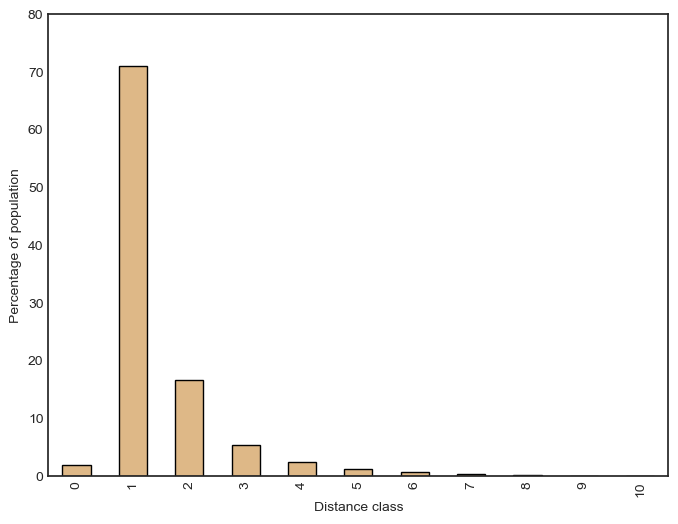

In [157]:
fig, ax = plt.subplots(figsize=(8,6))
pd.DataFrame(access.groupby('cls')['Zpct'].sum()).reset_index().merge(access_zone_classes['Distance'],left_index=True,right_index=True)['Zpct'].plot(x='cls',kind='bar',color='burlywood',ax=ax,edgecolor='black')
plt.xlabel("Distance class")
plt.ylabel("Percentage of population")
ax.set_ylim([0,80])
plt.savefig('20210930_PeopleRangeScenarioNoFloods.svg',format='svg')
plt.savefig('20210930_PeopleRangeScenarioNoFloods.eps',format='eps')

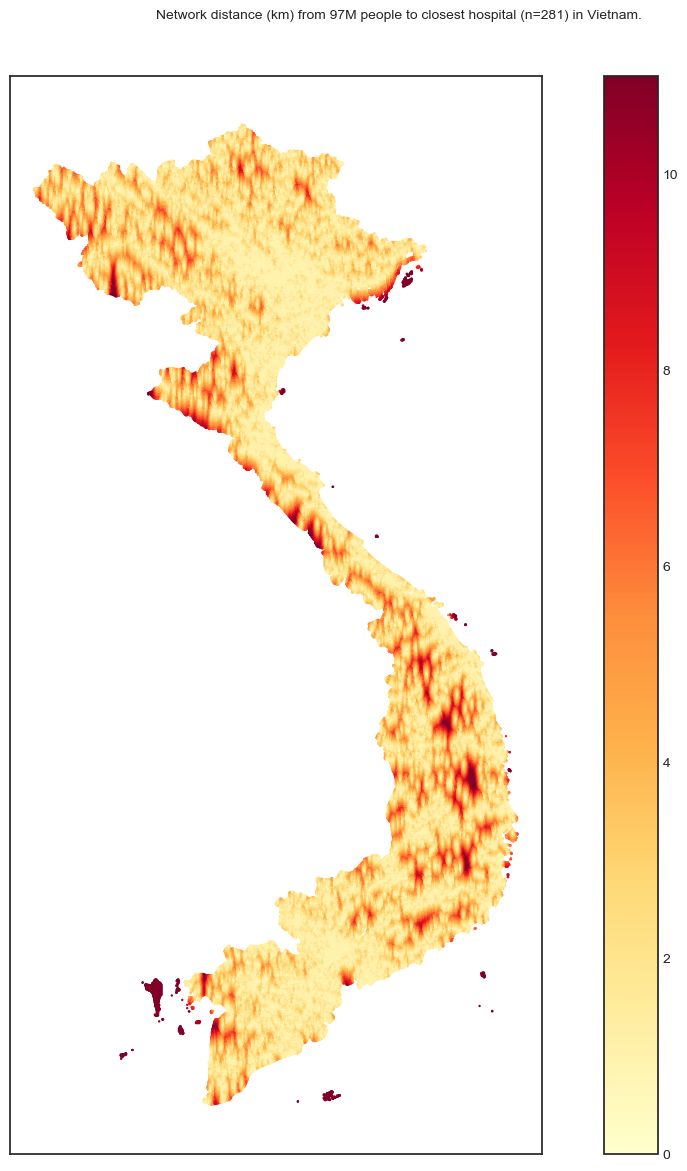

In [146]:
plt.style.use('seaborn-white')

#plt.subplots(1,2)

fig, ax = plt.subplots(figsize=(16,14))
access.plot(ax=ax,column="travel_distance", markersize=0.5, legend=True, cmap="YlOrRd", figsize=(17,10))

ax.tick_params(
    axis='both', bottom=False, left=False,         
    labelbottom=False, labelleft=False) 

# Adjust the map extent
#ax.set_xlim(22.5, 30.5)
#ax.set_ylim(57.4, 59.9)
# Add some useful info
ax.text(x=104, y=25, s=f"Network distance (km) from {round(pop['Z'].sum()/1000000)}M people to closest hospital (n={src_cnt}) in Vietnam.")
#ax.text(x=114,y=8, s=pd.DataFrame(access.groupby('cls')['Zpct'].sum()).reset_index().merge(access_zone_classes['Distance'],left_index=True,right_index=True).to_string(index=False),
#        ha='right', linespacing=1.1);

plt.savefig('20210930_NetworkDistanceScenarioNoFloods.svg',format='svg')
plt.savefig('20210930_NetworkDistanceScenarioNoFloods.eps',format='eps')

In [93]:
access_zone_classes

,Distance,% of pop nodes
0,0-1,0.304
1,1-2,0.272
2,2-3,0.170
3,3-4,0.104
4,4-5,0.064
5,5-6,0.039
6,6-7,0.021
7,7-8,0.010
8,8-9,0.005
9,9-10,0.003


<AxesSubplot:>

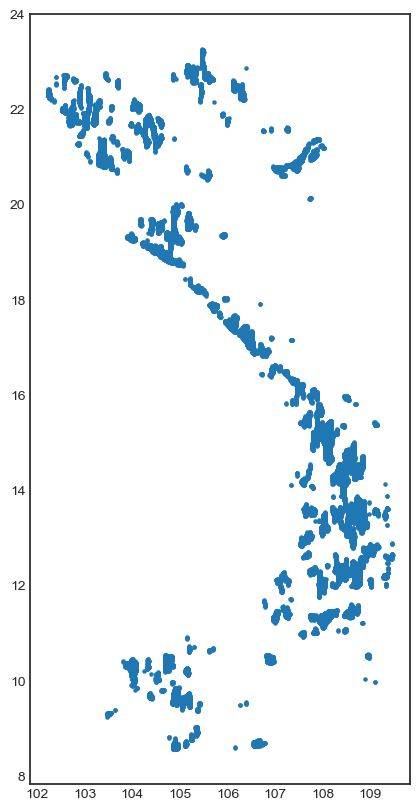

In [94]:
access[access['distance_km'] > 5].plot(markersize=5, figsize=(17,10))

In [95]:
#access['distance'].plot(kind='bar')